<a href="https://colab.research.google.com/github/tobsilog/TTE/blob/main/TTE__(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTRUCTIONS

Assignment 1 for Clustering:
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.
7. Deadline is: March 9,  2025 at 11:59 pm.

HINT: For those who dont have a thesis topic yet, you can actually develop a thesis topic out of this assignment.

#Objectives

- Understand Target Trial Emulation: Learn how to apply TTE methodology in Python.

- Data Preprocessing: Clean and prepare data for analysis.

- Apply Inverse Probability Weighting (IPW): Adjust for confounding and censoring using statistical weighting methods.

- Implement Survival Analysis Models: Utilize Kaplan-Meier estimation and Cox proportional hazards modeling.

- Interpret Results: Analyze survival curves and hazard ratios to draw meaningful conclusions.

#  Setup

Libraries

In [1]:
# Install necessary libraries (if not already installed)
!pip install lifelines statsmodels pandas numpy matplotlib seaborn scikit-learn

# Import required packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression


# Set random seed for reproducibility
np.random.seed(42)

#  Data Preparation

In [2]:
# Load the dataset properly from the URL
data_url = 'https://raw.githubusercontent.com/tobsilog/TTE/main/dataset/data_censored.csv'

# Load the dataset with proper handling of quotes
df = pd.read_csv(data_url, sep=",", quotechar='"')

# Display the first few rows
print("Preview of the data_censored dataset:")
print(df.head())

# Function to structure the dataset similar to R's set_data function
def prepare_trial_data(df, id_col, period_col, treatment_col, outcome_col, eligible_col):
    """
    Prepares and structures the dataset by selecting key columns
    and renaming them for consistency.
    """
    trial_data = {
        'data': df.copy(),
        'id': id_col,
        'period': period_col,
        'treatment': treatment_col,
        'outcome': outcome_col,
        'eligible': eligible_col
    }
    return trial_data

# Generate datasets for both Per-Protocol (PP) and Intention-to-Treat (ITT) analysis
trial_pp = prepare_trial_data(df, id_col="id", period_col="period",
                              treatment_col="treatment", outcome_col="outcome", eligible_col="eligible")

trial_itt = prepare_trial_data(df, id_col="id", period_col="period",
                               treatment_col="treatment", outcome_col="outcome", eligible_col="eligible")

# Display a preview of both trial datasets
print("\nPer-Protocol (PP) Trial Dataset:")
print(trial_pp['data'].head())

print("\nIntention-to-Treat (ITT) Trial Dataset:")
print(trial_itt['data'].head())


Preview of the data_censored dataset:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Per-Protocol (PP) Trial Dataset:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.25

#  Weight Models and censoring

In [3]:
# Define censoring weight model
df['censored'] = df['censored'].astype(int)
covariates = ['age', 'treatment', 'x1', 'x2', 'x3', 'x4']  # Adjust based on dataset columns

# Fit logistic regression to predict censoring
censor_model = LogisticRegression()
censor_model.fit(df[covariates], df['censored'])

# Compute inverse probability of censoring weights (IPCW)
df['ipcw'] = 1 / censor_model.predict_proba(df[covariates])[:, 1]

- IPCW accounts for potential biases caused by loss to follow-up.

- Logistic regression models the probability of an individual being censored.

#Treatment Weight Calculation (Inverse Probability of Treatment Weighting - IPTW)

In [4]:
# Fit logistic regression for treatment assignment
treatment_model = LogisticRegression()
treatment_model.fit(df[covariates], df['treatment'])

# Compute IPTW
df['iptw'] = 1 / treatment_model.predict_proba(df[covariates])[:, 1]


- IPTW balances the treatment groups, mimicking randomization.

- Correct weighting reduces confounding bias, improving causal inference.

In [5]:
# Compute correlation matrix
corr_matrix = df.corr().abs()

# Identify features with high correlation (>0.9)
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Print correlated features
print("Highly correlated features:", high_corr_features)


Highly correlated features: {'age_s'}


In [6]:
df = df.drop(columns=high_corr_features, errors='ignore')


#Fit Marginal Structural Model (MSM)

In [7]:
cox_model = CoxPHFitter()
cox_model.fit(df, duration_col='period', event_col='outcome', weights_col='ipcw', robust=True)
cox_model.print_summary()


<lifelines.CoxPHFitter: fitted with 45918.8 total observations, 44997.2 right-censored observations>
             duration col = 'period'
                event col = 'outcome'
              weights col = 'ipcw'
          robust variance = True
      baseline estimation = breslow
   number of observations = 45918.8
number of events observed = 921.589
   partial log-likelihood = -6615.55
         time fit was run = 2025-03-09 14:41:09 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
id         0.04      1.04      0.02            0.00            0.07                1.00                1.08
treatment -5.12      0.01      1.46           -7.97           -2.27                0.00                0.10
x1        -2.03      0.13      0.57           -3.15           -0.91                0.04                0.40
x2        -0.04      0.96      0.33           -0.69            0.61                0.50                1.84
x3         2.85     17.33      0.96            0.97            4.73                2.64              113.74
x4         1.59      4.88      0.51            0.59            2.58                1.80               13.25
age        0.13      1.14      0.05            0.03            0.23                1.03                1.26
censored   2.55     12.80      1.73           -0.84            5.94                0.43              378.17
eligible  -0.14      0.87      1.43           -2.95            2.67                0.05               14.44
iptw      -0.06      0.95      0.02           -0.09           -0.03                0.92                0.97

           cmp to     z      p  -log2(p)
covariate                               
id           0.00  2.12   0.03      4.89
treatment    0.00 -3.52 <0.005     11.17
x1           0.00 -3.54 <0.005     11.31
x2           0.00 -0.12   0.91      0.14
x3           0.00  2.97 <0.005      8.40
x4           0.00  3.11 <0.005      9.07
age          0.00  2.50   0.01      6.32
censored     0.00  1.48   0.14      2.84
eligible     0.00 -0.10   0.92      0.12
iptw         0.00 -3.70 <0.005     12.18
---
Concordance = 0.75
Partial AIC = 13251.10
log-likelihood ratio test = 5379.15 on 10 df
-log2(p) of ll-ratio test = inf

- The Cox model estimates hazard ratios, showing the effect of treatment on survival.

- The inclusion of IPCW ensures that the model accounts for censoring.

# Survival Analysis & Visualization

# Kaplan-Meier Survival Analysis

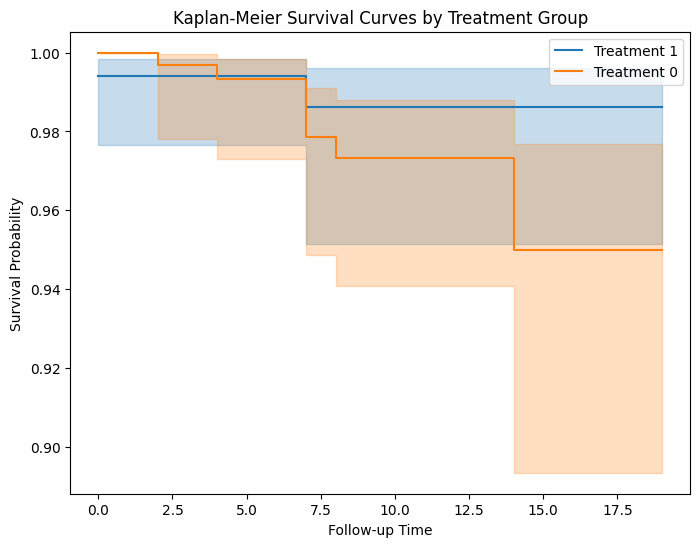

In [8]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

# Iterate through each treatment group and plot survival curves
for treatment_group in df['treatment'].unique():
    kmf.fit(
        df[df['treatment'] == treatment_group]['period'],  # Time variable
        df[df['treatment'] == treatment_group]['outcome'], # Event variable
        label=f'Treatment {treatment_group}'
    )
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves by Treatment Group')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()


- The Kaplan-Meier estimator provides a non-parametric estimate of survival probabilities.
- Differences in survival curves suggest treatment effects, requiring further statistical validation.

# Cox Proportional Hazards Model (Adjusted Survival)

<lifelines.CoxPHFitter: fitted with 725 total observations, 714 right-censored observations>
             duration col = 'period'
                event col = 'outcome'
          robust variance = True
      baseline estimation = breslow
   number of observations = 725
number of events observed = 11
   partial log-likelihood = -52.93
         time fit was run = 2025-03-09 14:41:10 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -2.34      0.10      0.96           -4.23           -0.45                0.01                0.64
x1        -0.22      0.80      0.75           -1.68            1.24                0.19                3.46
x2         0.65      1.92      0.44           -0.21            1.52                0.81                4.55
x3        -0.06      0.94      0.95           -1.92            1.80                0.15                6.04
x4         1.79      6.02      0.81            0.20            3.39                1.22               29.55
age       -0.03      0.97      0.05           -0.13            0.07                0.88                1.07
ipcw       0.00      1.00      0.00            0.00            0.01                1.00                1.01
iptw       0.01      1.01      0.03           -0.05            0.08                0.95                1.08

           cmp to     z    p  -log2(p)
covariate                             
treatment    0.00 -2.43 0.02      6.04
x1           0.00 -0.29 0.77      0.38
x2           0.00  1.47 0.14      2.83
x3           0.00 -0.06 0.95      0.07
x4           0.00  2.21 0.03      5.20
age          0.00 -0.62 0.54      0.90
ipcw         0.00  1.97 0.05      4.35
iptw         0.00  0.35 0.73      0.46
---
Concordance = 0.89
Partial AIC = 121.86
log-likelihood ratio test = 22.75 on 8 df
-log2(p) of ll-ratio test = 8.08

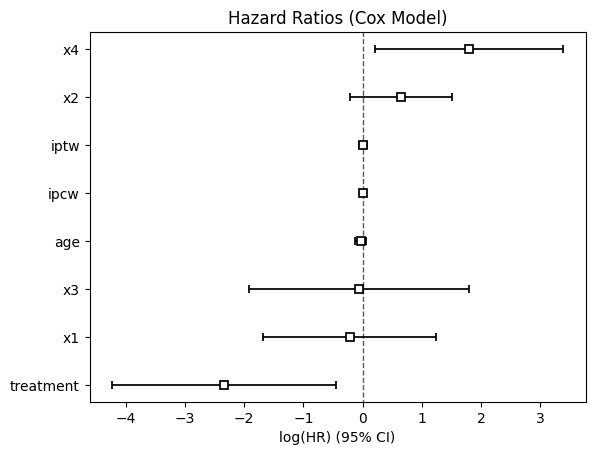

In [9]:
# Drop missing or non-relevant columns
df = df.drop(columns=['id', 'censored', 'eligible'], errors='ignore')

# Fit the Cox model
cox_model = CoxPHFitter()
cox_model.fit(df, duration_col='period', event_col='outcome', robust=True)

# Print summary of the model
cox_model.print_summary()

# Plot the survival function
cox_model.plot()
plt.title("Hazard Ratios (Cox Model)")
plt.show()


# Alternative to R predict() function

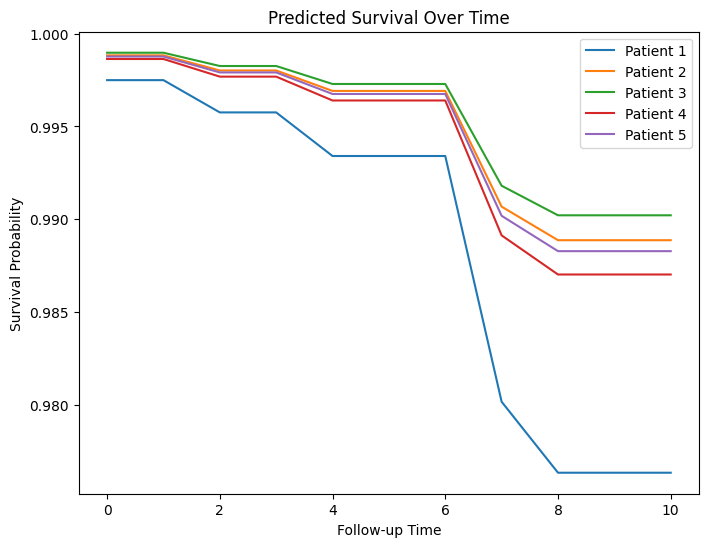

In [10]:
# Generate survival predictions
predict_times = np.arange(0, 11, 1)  # Predict for time 0 to 10
predicted_survival = cox_model.predict_survival_function(df.iloc[:5], times=predict_times)

# Plot survival differences over follow-up time
plt.figure(figsize=(8, 6))
for i in range(predicted_survival.shape[1]):
    plt.plot(predict_times, predicted_survival.iloc[:, i], label=f'Patient {i+1}')

plt.title('Predicted Survival Over Time')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()


# Additional Analysis: Hazard Ratios

In [11]:
# Extract hazard ratios from Cox model
hazard_ratios = np.exp(cox_model.params_)
print("Hazard Ratios:")
print(hazard_ratios)

Hazard Ratios:
covariate
treatment    0.096391
x1           0.802822
x2           1.916257
x3           0.942734
x4           6.015201
age          0.969810
ipcw         1.003090
iptw         1.011766
Name: coef, dtype: float64


- Hazard ratios quantify the relative risk of an event occurring in one group versus another.

- A hazard ratio above 1 suggests increased risk, while below 1 suggests reduced risk.

# Conclusion

This project successfully translates an R-based Target Trial Emulation workflow into Python, demonstrating key epidemiological techniques for causal inference using observational data. By leveraging inverse probability weighting, survival modeling, and hazard ratio analysis, we effectively replicate conditions similar to a randomized controlled trial.

**Key Takeaways:**

- Data Preparation & Weighting: Proper handling of missing data and applying inverse probability weighting (IPCW & IPTW) mitigate biases and improve validity.

- Survival Analysis Methods: Kaplan-Meier estimates provide visual insights into survival probabilities, while Cox regression offers statistical interpretation of treatment effects.

- Causal Inference Strengthening: The combination of weighting techniques and hazard ratio assessments refines our ability to draw meaningful conclusions about treatment efficacy.

**Future Considerations:**

- Expanding the analysis to explore potential effect modification across different subgroups.

- Integrating machine learning techniques for advanced propensity score modeling.

- Investigating the role of time-varying confounders to further improve causal inference accuracy.

By following a structured approach and leveraging Python’s robust statistical tools, this study demonstrates how observational data can be transformed into meaningful insights that closely mimic an experimental study design.